In [1]:
import joblib, tqdm, torch

import numpy as np

from model.classifier import Classifier
from utils.trainer import train
from utils.dataloader import split
from utils.get_labels import label_pts
from utils.generate_data import xmin, xmax, ymin, ymax, b1, b2

import matplotlib.pyplot as plt
plt.style.use('bmh')

# Load data

We define a synthetic dataset with 3 classes over a 2-D feature space.

The boundaries of the dataset can be seen below:

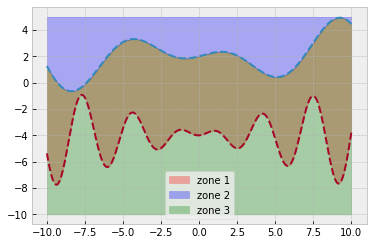

In [2]:
data = joblib.load('data/dataset_init.pt')

x = np.linspace(xmin, xmax, 1000)

bound1 = b1(x)
bound2 = b2(x)

plt.figure()
plt.plot(x, bound1, '--', label='_nolegend_')
plt.plot(x, bound2, '--', label='_nolegend_')

plt.fill_between(x, bound2, bound1, color = 'r', alpha = .3)
plt.fill_between(x, bound1, ymax, color = 'b', alpha = .3)
plt.fill_between(x, ymin, bound1, color='g', alpha=.3)

plt.legend(['zone 1', 'zone 2', 'zone 3'])
plt.show()


Our goal is to learn an accurate classification rule from data that can be sampled in the space.

Let's say we start off with a labeled dataset such as the following :

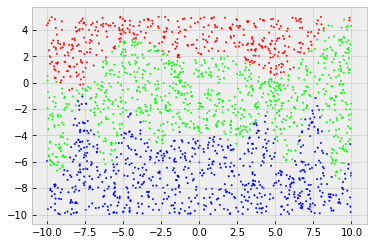

In [3]:
cloud = data['x']
labels = data['y']

plt.figure()
plt.scatter(cloud[:, 0], cloud[:, 1], c = labels, s = 2)
plt.show()

Clearly, this data is not enough to model transition boundaries with high precision, so the goal is to progressivey augment the dataset with samples that are close the boundaries in an Active learning framework.

Let's start with a classical training of the model.

In [4]:
data_train, data_test = split(data, perc = .75)

model = Classifier(input_dim = 2, output_dim = 3).to('cpu')
model.device = 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = torch.nn.CrossEntropyLoss()

metrics1 = train(model, data_train, data_test, optimizer, criterion, active= False, n_epochs = 300, log=50)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
metrics2 = train(model, data_train, data_test, optimizer, criterion, active = False, n_epochs = 400, log=50)

metrics = {}
for k in metrics1.keys():
    metrics[k] = np.concatenate((metrics1[k], metrics2[k]))


  0%|          | 1/300 [00:00<00:59,  4.99it/s]

epoch : 0 - L_train : 0.013073543747266134 - L_val : 0.012474604964256286


 17%|█▋        | 51/300 [00:07<00:28,  8.60it/s]

epoch : 50 - L_train : 0.010269879579544068 - L_val : 0.010752022027969361


 34%|███▍      | 102/300 [00:13<00:21,  9.18it/s]

epoch : 100 - L_train : 0.010513726115226746 - L_val : 0.01110918927192688


 51%|█████     | 152/300 [00:18<00:17,  8.36it/s]

epoch : 150 - L_train : 0.00999807902177175 - L_val : 0.010790638446807862


 67%|██████▋   | 202/300 [00:24<00:13,  7.26it/s]

epoch : 200 - L_train : 0.010202582319577535 - L_val : 0.01064086651802063


 84%|████████▍ | 252/300 [00:31<00:06,  6.87it/s]

epoch : 250 - L_train : 0.010157161593437195 - L_val : 0.010716097354888916


  0%|          | 1/400 [00:00<00:43,  9.12it/s]

Done training.
epoch : 0 - L_train : 0.010015313824017843 - L_val : 0.010590999245643615


 13%|█▎        | 52/400 [00:07<00:57,  6.09it/s]

epoch : 50 - L_train : 0.00986034385363261 - L_val : 0.01050461721420288


 26%|██▌       | 102/400 [00:14<00:39,  7.53it/s]

epoch : 100 - L_train : 0.00982789158821106 - L_val : 0.010521260738372803


 38%|███▊      | 152/400 [00:21<00:38,  6.50it/s]

epoch : 150 - L_train : 0.009848017573356628 - L_val : 0.010522887587547302


 50%|█████     | 202/400 [00:28<00:28,  7.06it/s]

epoch : 200 - L_train : 0.009783853411674499 - L_val : 0.010526583194732667


 63%|██████▎   | 252/400 [00:34<00:20,  7.24it/s]

epoch : 250 - L_train : 0.009767597198486327 - L_val : 0.010494865775108338


 75%|███████▌  | 301/400 [00:42<00:24,  4.10it/s]

epoch : 300 - L_train : 0.009761378606160482 - L_val : 0.010406826972961426


 88%|████████▊ | 352/400 [00:50<00:06,  7.68it/s]

epoch : 350 - L_train : 0.009759942650794983 - L_val : 0.010437912821769714


100%|██████████| 400/400 [00:57<00:00,  7.01it/s]

Done training.


We can clearly see that the model fails to learn the correct boundary, especially since more importance is given to data that is not along the boundaries, which is therefore more numerous and frequent during the training process.

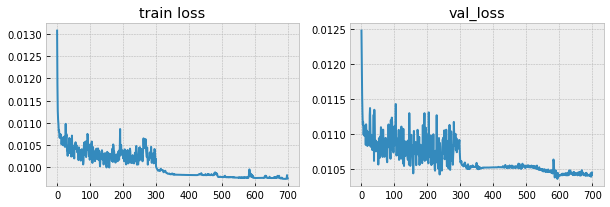

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(metrics['L_train'])
ax[0].set_title('train loss')

ax[1].plot(metrics['L_val'])
ax[1].set_title('val_loss')
plt.show()

Let's see how well the model is able to separate th different domains.

In [6]:
labels_pred = model(torch.tensor(data_test['x']).float().to(model.device)).detach().numpy()

Text(0.5, 1.0, 'predictions')

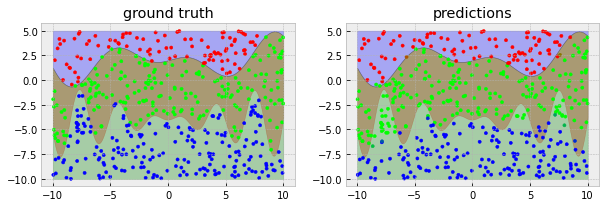

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].fill_between(x, bound2, bound1, color = 'r', alpha = .3)
ax[0].fill_between(x, bound1, ymax, color = 'b', alpha = .3)
ax[0].fill_between(x, ymin, bound1, color='g', alpha=.3)
ax[0].scatter(data_test['x'][:, 0], data_test['x'][:, 1], c = data_test['y'], s = 10)
ax[0].set_title('ground truth')

ax[1].fill_between(x, bound2, bound1, color = 'r', alpha = .3)
ax[1].fill_between(x, bound1, ymax, color = 'b', alpha = .3)
ax[1].fill_between(x, ymin, bound1, color='g', alpha=.3)
ax[1].scatter(data_test['x'][:, 0], data_test['x'][:, 1], c = labels_pred, s =10)
ax[1].set_title('predictions')

In [8]:
n_pts = 20000
cloud = np.random.uniform(low=0, high = 1, size = (n_pts, 2))
cloud[:, 0] = cloud[:, 0]*(xmax - xmin) + xmin
cloud[:, 1] = cloud[:, 1]*(ymax - ymin) + ymin

cloud_pred = model(torch.tensor(cloud).float().to(model.device)).detach().numpy()
cloud_labels = label_pts(cloud)

Text(0.5, 1.0, 'predictions')

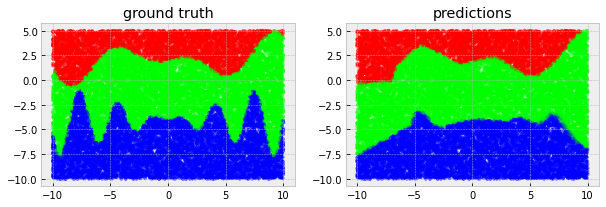

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].scatter(cloud[:, 0], cloud[:, 1], c = cloud_labels, s = 10, alpha = .5)
ax[0].set_title('ground truth')

ax[1].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred, s =10, alpha = .5)
ax[1].set_title('predictions')

# Approach 1

To obtain better results, we adopt the following approach :

During each training iteration, we keep track of the elements where the error on the confidence score is superior to a constant threshold and add it to a queue.

$$|1 - \mathbb{P}(\hat{y}/x)| > 1 - \epsilon$$

Afterwards, we sample points on the neighborhood of this set and generate their corresponding labels.

Finally, this new dataset is used to fit the model before going to the nex epoch.

In [11]:
model2 = Classifier(input_dim = 2, output_dim = 3).to('cpu')
model2.device = 'cpu'
optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-2)
criterion = torch.nn.CrossEntropyLoss()

metrics1 = train(model2, data_train, data_test, optimizer, criterion, active = True, n_epochs = 300, log=50)

optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-3)
metrics2 = train(model2, data_train, data_test, optimizer, criterion, active = True, n_epochs = 400, log=50)

metrics = {}
for k in metrics1.keys():
    metrics[k] = np.concatenate((metrics1[k], metrics2[k]))

  0%|          | 1/300 [00:00<01:41,  2.95it/s]

epoch : 0 - L_train : 0.01298218023777008 - L_val : 0.01217199730873108


 17%|█▋        | 51/300 [00:14<00:56,  4.41it/s]

epoch : 50 - L_train : 0.010622811396916707 - L_val : 0.011064105153083802


 17%|█▋        | 52/300 [00:15<01:06,  3.73it/s]

dumping
dumping

 18%|█▊        | 53/300 [00:15<01:00,  4.06it/s]

 18%|█▊        | 54/300 [00:15<01:03,  3.88it/s]

dumping
dumping

 18%|█▊        | 55/300 [00:15<00:58,  4.21it/s]


dumping

 19%|█▊        | 56/300 [00:15<00:54,  4.51it/s]


dumping

 19%|█▉        | 57/300 [00:16<00:51,  4.70it/s]


dumping


 20%|█▉        | 59/300 [00:16<00:48,  5.02it/s]

dumping


 20%|██        | 60/300 [00:16<00:52,  4.57it/s]

dumping
dumping

 20%|██        | 61/300 [00:16<00:51,  4.62it/s]


dumping

 21%|██        | 62/300 [00:17<00:49,  4.83it/s]


dumping

 21%|██        | 63/300 [00:17<00:48,  4.90it/s]


dumping

 21%|██▏       | 64/300 [00:17<00:46,  5.06it/s]

 22%|██▏       | 65/300 [00:17<00:49,  4.72it/s]

dumping
dumping


 22%|██▏       | 67/300 [00:18<00:47,  4.93it/s]

dumping
dumping

 23%|██▎       | 68/300 [00:18<00:46,  4.95it/s]

 23%|██▎       | 69/300 [00:18<00:48,  4.80it/s]

dumping
dumping

 23%|██▎       | 70/300 [00:18<00:50,  4.55it/s]

 24%|██▎       | 71/300 [00:18<00:47,  4.77it/s]

dumping
dumping

 24%|██▍       | 72/300 [00:19<00:46,  4.90it/s]


dumping

 24%|██▍       | 73/300 [00:19<00:46,  4.87it/s]

 25%|██▍       | 74/300 [00:19<00:46,  4.91it/s]

dumping
dumping

 25%|██▌       | 75/300 [00:19<00:45,  4.97it/s]

 25%|██▌       | 76/300 [00:20<00:50,  4.48it/s]

dumping
dumping

 26%|██▌       | 77/300 [00:20<00:49,  4.50it/s]

 26%|██▌       | 78/300 [00:20<00:50,  4.42it/s]

dumping


 26%|██▋       | 79/300 [00:20<00:49,  4.49it/s]

dumping


 27%|██▋       | 80/300 [00:21<00:54,  4.07it/s]

dumping


 27%|██▋       | 81/300 [00:21<00:50,  4.31it/s]

dumping
dumping

 27%|██▋       | 82/300 [00:21<00:50,  4.32it/s]

 28%|██▊       | 83/300 [00:21<00:50,  4.33it/s]

dumping


 28%|██▊       | 84/300 [00:21<00:48,  4.42it/s]

dumping


 28%|██▊       | 85/300 [00:22<00:52,  4.10it/s]

dumping


 29%|██▊       | 86/300 [00:22<00:50,  4.20it/s]

dumping
dumping

 29%|██▉       | 87/300 [00:22<00:48,  4.38it/s]

 29%|██▉       | 88/300 [00:22<00:48,  4.37it/s]

dumping


 30%|██▉       | 89/300 [00:23<00:48,  4.39it/s]

dumping


 30%|███       | 90/300 [00:23<00:59,  3.54it/s]

dumping


 30%|███       | 91/300 [00:23<00:55,  3.77it/s]

dumping
dumping

 31%|███       | 92/300 [00:23<00:51,  4.06it/s]

 31%|███       | 93/300 [00:24<00:49,  4.21it/s]

dumping


 31%|███▏      | 94/300 [00:24<00:53,  3.83it/s]

dumping


 32%|███▏      | 95/300 [00:24<00:51,  3.95it/s]

dumping


 32%|███▏      | 96/300 [00:24<00:49,  4.09it/s]

dumping


 32%|███▏      | 97/300 [00:25<00:48,  4.19it/s]

dumping


 33%|███▎      | 98/300 [00:25<00:48,  4.15it/s]

dumping


 33%|███▎      | 99/300 [00:25<00:51,  3.94it/s]

dumping


 33%|███▎      | 100/300 [00:25<00:49,  4.05it/s]

dumping
dumping

 34%|███▎      | 101/300 [00:26<00:46,  4.32it/s]


epoch : 100 - L_train : 0.01040502933661143 - L_val : 0.011021400213241578


 34%|███▍      | 102/300 [00:26<00:44,  4.44it/s]

dumping


 34%|███▍      | 103/300 [00:26<00:43,  4.57it/s]

dumping


 35%|███▍      | 104/300 [00:26<00:45,  4.33it/s]

dumping
dumping

 35%|███▌      | 105/300 [00:26<00:44,  4.39it/s]

 35%|███▌      | 106/300 [00:27<00:43,  4.50it/s]

dumping


 36%|███▌      | 107/300 [00:27<00:43,  4.45it/s]

dumping


 36%|███▌      | 108/300 [00:27<00:43,  4.42it/s]

dumping


 36%|███▋      | 109/300 [00:27<00:46,  4.07it/s]

dumping
dumping

 37%|███▋      | 110/300 [00:28<00:44,  4.24it/s]


dumping

 37%|███▋      | 111/300 [00:28<00:43,  4.38it/s]

 37%|███▋      | 112/300 [00:28<00:43,  4.34it/s]

dumping


 38%|███▊      | 113/300 [00:28<00:47,  3.98it/s]

dumping


 38%|███▊      | 114/300 [00:29<00:45,  4.11it/s]

dumping
dumping

 38%|███▊      | 115/300 [00:29<00:42,  4.34it/s]

 39%|███▊      | 116/300 [00:29<00:41,  4.43it/s]

dumping
dumping

 39%|███▉      | 117/300 [00:29<00:41,  4.44it/s]

 39%|███▉      | 118/300 [00:30<00:45,  4.01it/s]

dumping


 40%|███▉      | 119/300 [00:30<00:44,  4.08it/s]

dumping


 40%|████      | 120/300 [00:30<00:43,  4.13it/s]

dumping
dumping

 40%|████      | 121/300 [00:30<00:43,  4.09it/s]

 41%|████      | 122/300 [00:31<00:52,  3.40it/s]

dumping


 41%|████      | 123/300 [00:31<00:51,  3.45it/s]

dumping


 41%|████▏     | 124/300 [00:31<00:50,  3.49it/s]

dumping


 42%|████▏     | 125/300 [00:32<00:50,  3.44it/s]

dumping


 42%|████▏     | 126/300 [00:32<00:53,  3.27it/s]

dumping


 42%|████▏     | 127/300 [00:32<00:51,  3.34it/s]

dumping


 43%|████▎     | 128/300 [00:32<00:51,  3.35it/s]

dumping


 43%|████▎     | 129/300 [00:33<00:50,  3.40it/s]

dumping


 43%|████▎     | 130/300 [00:33<00:53,  3.17it/s]

dumping


 44%|████▎     | 131/300 [00:33<00:50,  3.37it/s]

dumping


 44%|████▍     | 132/300 [00:34<00:51,  3.27it/s]

dumping


 44%|████▍     | 133/300 [00:34<00:50,  3.34it/s]

dumping


 45%|████▍     | 134/300 [00:34<00:49,  3.35it/s]

dumping


 45%|████▌     | 135/300 [00:35<00:47,  3.45it/s]

dumping


 45%|████▌     | 136/300 [00:35<00:45,  3.64it/s]

dumping


 46%|████▌     | 137/300 [00:35<00:43,  3.72it/s]

dumping


 46%|████▌     | 138/300 [00:35<00:46,  3.46it/s]

dumping


 46%|████▋     | 139/300 [00:36<00:45,  3.53it/s]

dumping


 47%|████▋     | 140/300 [00:36<00:43,  3.70it/s]

dumping


 47%|████▋     | 141/300 [00:36<00:42,  3.70it/s]

dumping


 47%|████▋     | 142/300 [00:37<00:45,  3.44it/s]

dumping


 48%|████▊     | 143/300 [00:37<00:43,  3.59it/s]

dumping


 48%|████▊     | 144/300 [00:37<00:42,  3.70it/s]

dumping


 48%|████▊     | 145/300 [00:37<00:41,  3.72it/s]

dumping


 49%|████▊     | 146/300 [00:38<00:44,  3.43it/s]

dumping


 49%|████▉     | 147/300 [00:38<00:44,  3.44it/s]

dumping


 49%|████▉     | 148/300 [00:38<00:41,  3.63it/s]

dumping


 50%|████▉     | 149/300 [00:38<00:40,  3.73it/s]

dumping


 50%|█████     | 150/300 [00:39<00:44,  3.38it/s]

dumping


 50%|█████     | 151/300 [00:39<00:42,  3.51it/s]

dumping
epoch : 150 - L_train : 0.010443706154823304 - L_val : 0.010921805858612061


 51%|█████     | 152/300 [00:39<00:41,  3.57it/s]

dumping


 51%|█████     | 153/300 [00:40<00:40,  3.67it/s]

dumping


 51%|█████▏    | 154/300 [00:40<00:48,  3.04it/s]

dumping


 52%|█████▏    | 155/300 [00:40<00:49,  2.96it/s]

dumping


 52%|█████▏    | 156/300 [00:41<00:45,  3.16it/s]

dumping


 52%|█████▏    | 157/300 [00:41<00:52,  2.74it/s]

dumping


 53%|█████▎    | 158/300 [00:41<00:48,  2.94it/s]

dumping


 53%|█████▎    | 159/300 [00:42<00:47,  2.97it/s]

dumping


 53%|█████▎    | 160/300 [00:42<00:50,  2.76it/s]

dumping


 54%|█████▎    | 161/300 [00:42<00:46,  2.97it/s]

dumping


 54%|█████▍    | 162/300 [00:43<00:42,  3.22it/s]

dumping


 54%|█████▍    | 163/300 [00:43<00:40,  3.41it/s]

dumping


 55%|█████▍    | 164/300 [00:43<00:43,  3.14it/s]

dumping


 55%|█████▌    | 165/300 [00:44<00:40,  3.34it/s]

dumping


 55%|█████▌    | 166/300 [00:44<00:38,  3.51it/s]

dumping


 56%|█████▌    | 167/300 [00:44<00:37,  3.53it/s]

dumping


 56%|█████▌    | 168/300 [00:44<00:39,  3.38it/s]

dumping


 56%|█████▋    | 169/300 [00:45<00:37,  3.51it/s]

dumping


 57%|█████▋    | 170/300 [00:45<00:35,  3.64it/s]

dumping


 57%|█████▋    | 171/300 [00:45<00:35,  3.66it/s]

dumping


 57%|█████▋    | 172/300 [00:45<00:36,  3.54it/s]

dumping


 58%|█████▊    | 173/300 [00:46<00:37,  3.37it/s]

dumping


 58%|█████▊    | 174/300 [00:46<00:39,  3.15it/s]

dumping


 58%|█████▊    | 175/300 [00:46<00:37,  3.33it/s]

dumping


 59%|█████▊    | 176/300 [00:47<00:40,  3.03it/s]

dumping


 59%|█████▉    | 177/300 [00:47<00:38,  3.21it/s]

dumping


 59%|█████▉    | 178/300 [00:47<00:36,  3.36it/s]

dumping


 60%|█████▉    | 179/300 [00:48<00:35,  3.43it/s]

dumping


 60%|██████    | 180/300 [00:48<00:37,  3.18it/s]

dumping


 60%|██████    | 181/300 [00:48<00:35,  3.32it/s]

dumping


 61%|██████    | 182/300 [00:49<00:34,  3.46it/s]

dumping


 61%|██████    | 183/300 [00:49<00:35,  3.29it/s]

dumping


 61%|██████▏   | 184/300 [00:49<00:35,  3.30it/s]

dumping


 62%|██████▏   | 185/300 [00:49<00:33,  3.43it/s]

dumping


 62%|██████▏   | 186/300 [00:50<00:31,  3.56it/s]

dumping


 62%|██████▏   | 187/300 [00:50<00:32,  3.51it/s]

dumping


 63%|██████▎   | 188/300 [00:50<00:32,  3.40it/s]

dumping


 63%|██████▎   | 189/300 [00:51<00:32,  3.45it/s]

dumping


 63%|██████▎   | 190/300 [00:51<00:30,  3.59it/s]

dumping


 64%|██████▎   | 191/300 [00:51<00:33,  3.28it/s]

dumping


 64%|██████▍   | 192/300 [00:51<00:31,  3.38it/s]

dumping


 64%|██████▍   | 193/300 [00:52<00:30,  3.52it/s]

dumping


 65%|██████▍   | 194/300 [00:52<00:29,  3.61it/s]

dumping


 65%|██████▌   | 195/300 [00:52<00:31,  3.31it/s]

dumping


 65%|██████▌   | 196/300 [00:53<00:29,  3.49it/s]

dumping


 66%|██████▌   | 197/300 [00:53<00:28,  3.59it/s]

dumping


 66%|██████▌   | 198/300 [00:53<00:28,  3.63it/s]

dumping


 66%|██████▋   | 199/300 [00:54<00:30,  3.35it/s]

dumping


 67%|██████▋   | 200/300 [00:54<00:29,  3.44it/s]

dumping


 67%|██████▋   | 201/300 [00:54<00:27,  3.58it/s]

dumping
epoch : 200 - L_train : 0.010591251452763876 - L_val : 0.011177689552307128


 67%|██████▋   | 202/300 [00:54<00:26,  3.71it/s]

dumping


 68%|██████▊   | 203/300 [00:55<00:28,  3.45it/s]

dumping


 68%|██████▊   | 204/300 [00:55<00:27,  3.48it/s]

dumping


 68%|██████▊   | 205/300 [00:55<00:26,  3.59it/s]

dumping


 69%|██████▊   | 206/300 [00:55<00:25,  3.66it/s]

dumping


 69%|██████▉   | 207/300 [00:56<00:28,  3.31it/s]

dumping


 69%|██████▉   | 208/300 [00:56<00:27,  3.38it/s]

dumping


 70%|██████▉   | 209/300 [00:56<00:26,  3.40it/s]

dumping


 70%|███████   | 210/300 [00:57<00:25,  3.52it/s]

dumping


 70%|███████   | 211/300 [00:57<00:27,  3.27it/s]

dumping


 71%|███████   | 212/300 [00:57<00:25,  3.45it/s]

dumping


 71%|███████   | 213/300 [00:57<00:24,  3.60it/s]

dumping


 71%|███████▏  | 214/300 [00:58<00:23,  3.65it/s]

dumping


 72%|███████▏  | 215/300 [00:58<00:24,  3.42it/s]

dumping


 72%|███████▏  | 216/300 [00:58<00:24,  3.47it/s]

dumping


 72%|███████▏  | 217/300 [00:59<00:23,  3.54it/s]

dumping


 73%|███████▎  | 218/300 [00:59<00:22,  3.57it/s]

dumping


 73%|███████▎  | 219/300 [00:59<00:24,  3.30it/s]

dumping


 73%|███████▎  | 220/300 [01:00<00:24,  3.28it/s]

dumping


 74%|███████▎  | 221/300 [01:00<00:23,  3.40it/s]

dumping


 74%|███████▍  | 222/300 [01:00<00:22,  3.46it/s]

dumping


 74%|███████▍  | 223/300 [01:00<00:23,  3.25it/s]

dumping


 75%|███████▍  | 224/300 [01:01<00:22,  3.33it/s]

dumping


 75%|███████▌  | 225/300 [01:01<00:23,  3.20it/s]

dumping


 75%|███████▌  | 226/300 [01:01<00:23,  3.10it/s]

dumping


 76%|███████▌  | 227/300 [01:02<00:22,  3.32it/s]

dumping


 76%|███████▌  | 228/300 [01:02<00:20,  3.46it/s]

dumping


 76%|███████▋  | 229/300 [01:02<00:19,  3.58it/s]

dumping


 77%|███████▋  | 230/300 [01:02<00:19,  3.68it/s]

dumping


 77%|███████▋  | 231/300 [01:03<00:20,  3.36it/s]

dumping


 77%|███████▋  | 232/300 [01:03<00:19,  3.49it/s]

dumping


 78%|███████▊  | 233/300 [01:03<00:18,  3.53it/s]

dumping


 78%|███████▊  | 234/300 [01:04<00:18,  3.62it/s]

dumping


 78%|███████▊  | 235/300 [01:04<00:19,  3.29it/s]

dumping


 79%|███████▊  | 236/300 [01:04<00:18,  3.46it/s]

dumping


 79%|███████▉  | 237/300 [01:05<00:18,  3.45it/s]

dumping


 79%|███████▉  | 238/300 [01:05<00:19,  3.13it/s]

dumping


 80%|███████▉  | 239/300 [01:05<00:18,  3.32it/s]

dumping


 80%|████████  | 240/300 [01:05<00:17,  3.49it/s]

dumping


 80%|████████  | 241/300 [01:06<00:16,  3.50it/s]

dumping


 81%|████████  | 242/300 [01:06<00:17,  3.29it/s]

dumping


 81%|████████  | 243/300 [01:06<00:17,  3.35it/s]

dumping


 81%|████████▏ | 244/300 [01:07<00:16,  3.40it/s]

dumping


 82%|████████▏ | 245/300 [01:07<00:15,  3.54it/s]

dumping


 82%|████████▏ | 246/300 [01:07<00:16,  3.36it/s]

dumping


 82%|████████▏ | 247/300 [01:07<00:15,  3.44it/s]

dumping


 83%|████████▎ | 248/300 [01:08<00:14,  3.52it/s]

dumping


 83%|████████▎ | 249/300 [01:08<00:14,  3.61it/s]

dumping


 83%|████████▎ | 250/300 [01:08<00:14,  3.35it/s]

dumping


 84%|████████▎ | 251/300 [01:09<00:14,  3.48it/s]

dumping
epoch : 250 - L_train : 0.010809274355570475 - L_val : 0.010823924541473389


 84%|████████▍ | 252/300 [01:09<00:13,  3.51it/s]

dumping


 84%|████████▍ | 253/300 [01:09<00:13,  3.53it/s]

dumping


 85%|████████▍ | 254/300 [01:10<00:13,  3.35it/s]

dumping


 85%|████████▌ | 255/300 [01:10<00:13,  3.37it/s]

dumping


 85%|████████▌ | 256/300 [01:10<00:12,  3.41it/s]

dumping


 86%|████████▌ | 257/300 [01:10<00:12,  3.57it/s]

dumping


 86%|████████▌ | 258/300 [01:11<00:12,  3.29it/s]

dumping


 86%|████████▋ | 259/300 [01:11<00:12,  3.39it/s]

dumping


 87%|████████▋ | 260/300 [01:11<00:11,  3.49it/s]

dumping


 87%|████████▋ | 261/300 [01:12<00:10,  3.57it/s]

dumping


 87%|████████▋ | 262/300 [01:12<00:11,  3.31it/s]

dumping


 88%|████████▊ | 263/300 [01:12<00:10,  3.45it/s]

dumping


 88%|████████▊ | 264/300 [01:12<00:10,  3.49it/s]

dumping


 88%|████████▊ | 265/300 [01:13<00:09,  3.59it/s]

dumping


 89%|████████▊ | 266/300 [01:13<00:10,  3.25it/s]

dumping


 89%|████████▉ | 267/300 [01:13<00:09,  3.43it/s]

dumping


 89%|████████▉ | 268/300 [01:14<00:09,  3.51it/s]

dumping


 90%|████████▉ | 269/300 [01:14<00:09,  3.35it/s]

dumping


 90%|█████████ | 270/300 [01:14<00:09,  3.12it/s]

dumping


 90%|█████████ | 271/300 [01:15<00:08,  3.29it/s]

dumping


 91%|█████████ | 272/300 [01:15<00:08,  3.48it/s]

dumping


 91%|█████████ | 273/300 [01:15<00:07,  3.43it/s]

dumping


 91%|█████████▏| 274/300 [01:15<00:07,  3.35it/s]

dumping


 92%|█████████▏| 275/300 [01:16<00:07,  3.45it/s]

dumping


 92%|█████████▏| 276/300 [01:16<00:06,  3.60it/s]

dumping


 92%|█████████▏| 277/300 [01:16<00:06,  3.50it/s]

dumping


 93%|█████████▎| 278/300 [01:17<00:06,  3.44it/s]

dumping


 93%|█████████▎| 279/300 [01:17<00:05,  3.51it/s]

dumping


 93%|█████████▎| 280/300 [01:17<00:05,  3.60it/s]

dumping


 94%|█████████▎| 281/300 [01:17<00:05,  3.71it/s]

dumping


 94%|█████████▍| 282/300 [01:18<00:05,  3.41it/s]

dumping


 94%|█████████▍| 283/300 [01:18<00:04,  3.53it/s]

dumping


 95%|█████████▍| 284/300 [01:18<00:04,  3.58it/s]

dumping


 95%|█████████▌| 285/300 [01:18<00:04,  3.65it/s]

dumping


 95%|█████████▌| 286/300 [01:19<00:04,  3.44it/s]

dumping


 96%|█████████▌| 287/300 [01:19<00:03,  3.48it/s]

dumping


 96%|█████████▌| 288/300 [01:19<00:03,  3.58it/s]

dumping


 96%|█████████▋| 289/300 [01:20<00:03,  3.64it/s]

dumping


 97%|█████████▋| 290/300 [01:20<00:02,  3.40it/s]

dumping


 97%|█████████▋| 291/300 [01:20<00:02,  3.58it/s]

dumping


 97%|█████████▋| 292/300 [01:20<00:02,  3.61it/s]

dumping


 98%|█████████▊| 293/300 [01:21<00:01,  3.72it/s]

dumping


 98%|█████████▊| 294/300 [01:21<00:01,  3.38it/s]

dumping
dumping


 99%|█████████▊| 296/300 [01:22<00:01,  3.23it/s]

dumping


 99%|█████████▉| 297/300 [01:22<00:00,  3.10it/s]

dumping


 99%|█████████▉| 298/300 [01:22<00:00,  3.03it/s]

dumping


100%|█████████▉| 299/300 [01:23<00:00,  3.19it/s]

dumping


  0%|          | 0/400 [00:00<?, ?it/s]

dumping
Done training.


  0%|          | 1/400 [00:00<02:10,  3.06it/s]

epoch : 0 - L_train : 0.010480922738711039 - L_val : 0.010732009768486024


 13%|█▎        | 51/400 [00:11<01:18,  4.45it/s]

epoch : 50 - L_train : 0.009968676487604777 - L_val : 0.01059042513370514
dumping

 13%|█▎        | 52/400 [00:11<01:20,  4.31it/s]

 13%|█▎        | 53/400 [00:11<01:35,  3.62it/s]

dumping


 14%|█▎        | 54/400 [00:12<01:35,  3.62it/s]

dumping


 14%|█▍        | 55/400 [00:12<01:34,  3.67it/s]

dumping


 14%|█▍        | 56/400 [00:12<01:40,  3.43it/s]

dumping


 14%|█▍        | 57/400 [00:13<01:39,  3.44it/s]

dumping


 14%|█▍        | 58/400 [00:13<01:36,  3.55it/s]

dumping


 15%|█▍        | 59/400 [00:13<01:32,  3.67it/s]

dumping


 15%|█▌        | 60/400 [00:13<01:30,  3.76it/s]

dumping


 15%|█▌        | 61/400 [00:14<01:38,  3.44it/s]

dumping


 16%|█▌        | 62/400 [00:14<01:35,  3.55it/s]

dumping


 16%|█▌        | 63/400 [00:14<01:32,  3.64it/s]

dumping


 16%|█▌        | 64/400 [00:14<01:31,  3.68it/s]

dumping


 16%|█▋        | 65/400 [00:15<01:39,  3.37it/s]

dumping


 16%|█▋        | 66/400 [00:15<01:35,  3.50it/s]

dumping


 17%|█▋        | 67/400 [00:15<01:31,  3.62it/s]

dumping


 17%|█▋        | 68/400 [00:16<01:31,  3.63it/s]

dumping


 17%|█▋        | 69/400 [00:16<01:40,  3.30it/s]

dumping


 18%|█▊        | 70/400 [00:16<01:34,  3.50it/s]

dumping


 18%|█▊        | 71/400 [00:16<01:32,  3.56it/s]

dumping


 18%|█▊        | 72/400 [00:17<01:36,  3.42it/s]

dumping


 18%|█▊        | 73/400 [00:17<01:37,  3.34it/s]

dumping


 18%|█▊        | 74/400 [00:17<01:37,  3.34it/s]

dumping


 19%|█▉        | 75/400 [00:18<01:34,  3.46it/s]

dumping


 19%|█▉        | 76/400 [00:18<01:41,  3.21it/s]

dumping


 19%|█▉        | 77/400 [00:18<01:34,  3.43it/s]

dumping


 20%|█▉        | 78/400 [00:19<01:32,  3.49it/s]

dumping


 20%|█▉        | 79/400 [00:19<01:30,  3.53it/s]

dumping


 20%|██        | 80/400 [00:19<01:37,  3.30it/s]

dumping


 20%|██        | 81/400 [00:19<01:33,  3.43it/s]

dumping


 20%|██        | 82/400 [00:20<01:28,  3.60it/s]

dumping


 21%|██        | 83/400 [00:20<01:27,  3.61it/s]

dumping


 21%|██        | 84/400 [00:20<01:34,  3.35it/s]

dumping


 21%|██▏       | 85/400 [00:21<01:29,  3.50it/s]

dumping


 22%|██▏       | 86/400 [00:21<01:27,  3.60it/s]

dumping


 22%|██▏       | 87/400 [00:21<01:25,  3.67it/s]

dumping


 22%|██▏       | 88/400 [00:21<01:33,  3.35it/s]

dumping


 22%|██▏       | 89/400 [00:22<01:30,  3.44it/s]

dumping


 22%|██▎       | 90/400 [00:22<01:27,  3.54it/s]

dumping


 23%|██▎       | 91/400 [00:22<01:25,  3.61it/s]

dumping


 23%|██▎       | 92/400 [00:23<01:31,  3.38it/s]

dumping


 23%|██▎       | 93/400 [00:23<01:28,  3.49it/s]

dumping


 24%|██▎       | 94/400 [00:23<01:25,  3.57it/s]

dumping


 24%|██▍       | 95/400 [00:23<01:24,  3.61it/s]

dumping


 24%|██▍       | 96/400 [00:24<01:33,  3.27it/s]

dumping


 24%|██▍       | 97/400 [00:24<01:33,  3.23it/s]

dumping


 24%|██▍       | 98/400 [00:24<01:35,  3.16it/s]

dumping


 25%|██▍       | 99/400 [00:25<01:38,  3.06it/s]

dumping


 25%|██▌       | 100/400 [00:25<01:40,  2.98it/s]

dumping


 25%|██▌       | 101/400 [00:25<01:33,  3.21it/s]

dumping
epoch : 100 - L_train : 0.00989226233959198 - L_val : 0.010656686663627625


 26%|██▌       | 102/400 [00:26<01:27,  3.42it/s]

dumping


 26%|██▌       | 103/400 [00:26<01:29,  3.30it/s]

dumping


 26%|██▌       | 104/400 [00:26<01:30,  3.28it/s]

dumping


 26%|██▋       | 105/400 [00:26<01:25,  3.43it/s]

dumping


 26%|██▋       | 106/400 [00:27<01:22,  3.55it/s]

dumping


 27%|██▋       | 107/400 [00:27<01:19,  3.66it/s]

dumping


 27%|██▋       | 108/400 [00:27<01:38,  2.96it/s]

dumping


 27%|██▋       | 109/400 [00:28<01:34,  3.10it/s]

dumping


 28%|██▊       | 110/400 [00:28<01:28,  3.29it/s]

dumping


 28%|██▊       | 111/400 [00:28<01:30,  3.18it/s]

dumping


 28%|██▊       | 112/400 [00:29<01:26,  3.34it/s]

dumping


 28%|██▊       | 113/400 [00:29<01:25,  3.37it/s]

dumping


 28%|██▊       | 114/400 [00:29<01:25,  3.36it/s]

dumping


 29%|██▉       | 115/400 [00:30<01:29,  3.20it/s]

dumping


 29%|██▉       | 116/400 [00:30<01:24,  3.37it/s]

dumping


 29%|██▉       | 117/400 [00:30<01:22,  3.41it/s]

dumping


 30%|██▉       | 118/400 [00:30<01:20,  3.52it/s]

dumping


 30%|██▉       | 119/400 [00:31<01:24,  3.33it/s]

dumping


 30%|███       | 120/400 [00:31<01:23,  3.37it/s]

dumping


 30%|███       | 121/400 [00:31<01:19,  3.50it/s]

dumping


 30%|███       | 122/400 [00:32<01:18,  3.53it/s]

dumping


 31%|███       | 123/400 [00:32<01:23,  3.33it/s]

dumping


 31%|███       | 124/400 [00:32<01:18,  3.53it/s]

dumping


 31%|███▏      | 125/400 [00:32<01:17,  3.57it/s]

dumping


 32%|███▏      | 126/400 [00:33<01:15,  3.64it/s]

dumping


 32%|███▏      | 127/400 [00:33<01:57,  2.33it/s]

dumping


 32%|███▏      | 128/400 [00:34<01:43,  2.63it/s]

dumping


 32%|███▏      | 129/400 [00:34<01:41,  2.67it/s]

dumping


 32%|███▎      | 130/400 [00:34<01:35,  2.83it/s]

dumping


 33%|███▎      | 131/400 [00:35<01:27,  3.09it/s]

dumping


 33%|███▎      | 132/400 [00:35<01:20,  3.34it/s]

dumping


 33%|███▎      | 133/400 [00:35<01:26,  3.09it/s]

dumping


 34%|███▎      | 134/400 [00:36<01:22,  3.23it/s]

dumping


 34%|███▍      | 135/400 [00:36<01:18,  3.40it/s]

dumping


 34%|███▍      | 136/400 [00:36<01:15,  3.50it/s]

dumping


 34%|███▍      | 137/400 [00:36<01:20,  3.25it/s]

dumping


 34%|███▍      | 138/400 [00:37<01:17,  3.38it/s]

dumping


 35%|███▍      | 139/400 [00:37<01:13,  3.55it/s]

dumping


 35%|███▌      | 140/400 [00:37<01:12,  3.58it/s]

dumping


 35%|███▌      | 141/400 [00:38<01:20,  3.21it/s]

dumping


 36%|███▌      | 142/400 [00:38<01:20,  3.20it/s]

dumping


 36%|███▌      | 143/400 [00:38<01:18,  3.28it/s]

dumping


 36%|███▌      | 144/400 [00:39<01:18,  3.26it/s]

dumping


 36%|███▋      | 145/400 [00:39<01:23,  3.04it/s]

dumping


 36%|███▋      | 146/400 [00:39<01:27,  2.89it/s]

dumping
dumping


 37%|███▋      | 148/400 [00:40<01:40,  2.51it/s]

dumping


 37%|███▋      | 149/400 [00:41<01:42,  2.45it/s]

dumping
dumping


 38%|███▊      | 151/400 [00:42<01:56,  2.14it/s]

dumping
epoch : 150 - L_train : 0.00990175187587738 - L_val : 0.01062704074382782


 38%|███▊      | 152/400 [00:42<01:44,  2.36it/s]

dumping


 38%|███▊      | 153/400 [00:42<01:33,  2.64it/s]

dumping


 38%|███▊      | 154/400 [00:43<01:24,  2.92it/s]

dumping


 39%|███▉      | 155/400 [00:43<01:17,  3.17it/s]

dumping


 39%|███▉      | 156/400 [00:43<01:18,  3.10it/s]

dumping


 39%|███▉      | 157/400 [00:43<01:13,  3.32it/s]

dumping


 40%|███▉      | 158/400 [00:44<01:09,  3.47it/s]

dumping


 40%|███▉      | 159/400 [00:44<01:07,  3.57it/s]

dumping


 40%|████      | 160/400 [00:44<01:11,  3.34it/s]

dumping


 40%|████      | 161/400 [00:45<01:07,  3.54it/s]

dumping


 40%|████      | 162/400 [00:45<01:05,  3.63it/s]

dumping


 41%|████      | 163/400 [00:45<01:03,  3.73it/s]

dumping


 41%|████      | 164/400 [00:45<01:07,  3.48it/s]

dumping


 41%|████▏     | 165/400 [00:46<01:03,  3.69it/s]

dumping


 42%|████▏     | 166/400 [00:46<01:04,  3.63it/s]

dumping


 42%|████▏     | 167/400 [00:46<01:00,  3.87it/s]

dumping
dumping


 42%|████▏     | 169/400 [00:47<00:54,  4.23it/s]

dumping
dumping


 43%|████▎     | 171/400 [00:47<00:45,  5.05it/s]

dumping
dumping


 43%|████▎     | 173/400 [00:47<00:39,  5.68it/s]

dumping
dumping


 44%|████▍     | 175/400 [00:48<00:42,  5.30it/s]

dumping


 44%|████▍     | 176/400 [00:48<00:42,  5.21it/s]

dumping


 44%|████▍     | 177/400 [00:48<00:42,  5.20it/s]

dumping
dumping


 45%|████▍     | 179/400 [00:48<00:38,  5.75it/s]

dumping
dumping


 45%|████▌     | 181/400 [00:49<00:39,  5.52it/s]

dumping
dumping

 46%|████▌     | 182/400 [00:49<00:40,  5.42it/s]


dumping


 46%|████▌     | 184/400 [00:49<00:38,  5.64it/s]

dumping
dumping


 46%|████▋     | 186/400 [00:50<00:35,  5.96it/s]

dumping
dumping


 47%|████▋     | 188/400 [00:50<00:38,  5.50it/s]

dumping
dumping


 48%|████▊     | 190/400 [00:50<00:37,  5.62it/s]

dumping
dumping


 48%|████▊     | 192/400 [00:51<00:35,  5.86it/s]

dumping
dumping


 48%|████▊     | 194/400 [00:51<00:38,  5.39it/s]

dumping


 49%|████▉     | 195/400 [00:51<00:38,  5.39it/s]

dumping
dumping


 49%|████▉     | 197/400 [00:51<00:36,  5.62it/s]

dumping
dumping


 50%|████▉     | 199/400 [00:52<00:34,  5.86it/s]

dumping
dumping


 50%|█████     | 201/400 [00:52<00:36,  5.51it/s]

dumping
epoch : 200 - L_train : 0.009844180822372437 - L_val : 0.010626511931419372
dumping


 51%|█████     | 203/400 [00:53<00:34,  5.77it/s]

dumping
dumping


 51%|█████▏    | 205/400 [00:53<00:32,  5.98it/s]

dumping
dumping


 52%|█████▏    | 207/400 [00:53<00:34,  5.53it/s]

dumping
dumping


 52%|█████▏    | 209/400 [00:54<00:33,  5.75it/s]

dumping
dumping


 53%|█████▎    | 211/400 [00:54<00:31,  6.01it/s]

dumping
dumping


 53%|█████▎    | 213/400 [00:54<00:34,  5.45it/s]

dumping


 54%|█████▎    | 214/400 [00:54<00:33,  5.57it/s]

dumping
dumping


 54%|█████▍    | 216/400 [00:55<00:32,  5.67it/s]

dumping
dumping


 55%|█████▍    | 218/400 [00:55<00:31,  5.81it/s]

dumping
dumping


 55%|█████▌    | 220/400 [00:56<00:33,  5.37it/s]

dumping
dumping


 56%|█████▌    | 222/400 [00:56<00:31,  5.68it/s]

dumping
dumping


 56%|█████▌    | 224/400 [00:56<00:30,  5.83it/s]

dumping
dumping


 56%|█████▋    | 226/400 [00:57<00:31,  5.45it/s]

dumping
dumping


 57%|█████▋    | 228/400 [00:57<00:29,  5.76it/s]

dumping
dumping


 57%|█████▊    | 230/400 [00:57<00:29,  5.81it/s]

dumping
dumping


 58%|█████▊    | 232/400 [00:58<00:31,  5.35it/s]

dumping
dumping


 58%|█████▊    | 234/400 [00:58<00:28,  5.90it/s]

dumping
dumping


 59%|█████▉    | 236/400 [00:58<00:28,  5.71it/s]

dumping
dumping


 60%|█████▉    | 238/400 [00:59<00:28,  5.64it/s]

dumping


 60%|█████▉    | 239/400 [00:59<00:29,  5.46it/s]

dumping
dumping

 60%|██████    | 240/400 [00:59<00:29,  5.50it/s]


dumping


 60%|██████    | 242/400 [00:59<00:27,  5.78it/s]

dumping
dumping


 61%|██████    | 244/400 [01:00<00:25,  6.08it/s]

dumping


 61%|██████▏   | 245/400 [01:00<00:28,  5.48it/s]

dumping
dumping


 62%|██████▏   | 247/400 [01:00<00:26,  5.68it/s]

dumping
dumping

 62%|██████▏   | 248/400 [01:00<00:27,  5.59it/s]


dumping


 62%|██████▎   | 250/400 [01:01<00:25,  5.90it/s]

dumping


 63%|██████▎   | 251/400 [01:01<00:28,  5.14it/s]

dumping
epoch : 250 - L_train : 0.00991210957368215 - L_val : 0.010610565423965454
dumping

 63%|██████▎   | 252/400 [01:01<00:28,  5.23it/s]

 63%|██████▎   | 253/400 [01:01<00:28,  5.19it/s]

dumping
dumping


 64%|██████▍   | 255/400 [01:02<00:26,  5.53it/s]

dumping
dumping


 64%|██████▍   | 257/400 [01:02<00:27,  5.29it/s]

dumping
dumping


 65%|██████▍   | 259/400 [01:02<00:27,  5.15it/s]

dumping
dumping


 65%|██████▌   | 261/400 [01:03<00:25,  5.40it/s]

dumping
dumping

 66%|██████▌   | 262/400 [01:03<00:25,  5.52it/s]

 66%|██████▌   | 263/400 [01:03<00:27,  4.91it/s]

dumping
dumping


 66%|██████▋   | 265/400 [01:04<00:24,  5.47it/s]

dumping
dumping


 67%|██████▋   | 267/400 [01:04<00:23,  5.58it/s]

dumping
dumping


 67%|██████▋   | 269/400 [01:04<00:24,  5.34it/s]

dumping
dumping


 68%|██████▊   | 271/400 [01:05<00:23,  5.60it/s]

dumping
dumping


 68%|██████▊   | 273/400 [01:05<00:24,  5.10it/s]

dumping
dumping

 68%|██████▊   | 274/400 [01:05<00:25,  4.88it/s]

 69%|██████▉   | 275/400 [01:05<00:26,  4.71it/s]

dumping
dumping

 69%|██████▉   | 276/400 [01:06<00:25,  4.95it/s]


dumping


 70%|██████▉   | 278/400 [01:06<00:23,  5.18it/s]

dumping
dumping


 70%|███████   | 280/400 [01:06<00:23,  5.21it/s]

dumping
dumping

 70%|███████   | 281/400 [01:07<00:22,  5.28it/s]


dumping

 70%|███████   | 282/400 [01:07<00:21,  5.37it/s]


dumping


 71%|███████   | 284/400 [01:07<00:20,  5.53it/s]

dumping
dumping


 72%|███████▏  | 286/400 [01:08<00:23,  4.95it/s]

dumping


 72%|███████▏  | 287/400 [01:08<00:21,  5.21it/s]

dumping
dumping


 72%|███████▏  | 289/400 [01:08<00:20,  5.32it/s]

dumping
dumping


 73%|███████▎  | 291/400 [01:08<00:19,  5.52it/s]

dumping
dumping


 73%|███████▎  | 293/400 [01:09<00:19,  5.37it/s]

dumping
dumping


 74%|███████▍  | 295/400 [01:09<00:18,  5.72it/s]

dumping
dumping


 74%|███████▍  | 297/400 [01:09<00:17,  5.73it/s]

dumping
dumping


 75%|███████▍  | 299/400 [01:10<00:19,  5.26it/s]

dumping
dumping


 75%|███████▌  | 301/400 [01:10<00:17,  5.56it/s]

dumping
epoch : 300 - L_train : 0.009834773500760396 - L_val : 0.010630501270294189
dumping


 76%|███████▌  | 303/400 [01:11<00:17,  5.50it/s]

dumping
dumping


 76%|███████▋  | 305/400 [01:11<00:18,  5.26it/s]

dumping
dumping


 77%|███████▋  | 307/400 [01:11<00:17,  5.34it/s]

dumping
dumping


 77%|███████▋  | 309/400 [01:12<00:15,  5.74it/s]

dumping
dumping


 78%|███████▊  | 311/400 [01:12<00:16,  5.37it/s]

dumping
dumping


 78%|███████▊  | 313/400 [01:12<00:15,  5.66it/s]

dumping
dumping


 79%|███████▉  | 315/400 [01:13<00:14,  5.78it/s]

dumping
dumping


 79%|███████▉  | 317/400 [01:13<00:15,  5.25it/s]

dumping
dumping

 80%|███████▉  | 318/400 [01:13<00:16,  5.09it/s]

 80%|███████▉  | 319/400 [01:14<00:16,  4.99it/s]

dumping
dumping

 80%|████████  | 320/400 [01:14<00:15,  5.25it/s]


dumping


 80%|████████  | 322/400 [01:14<00:14,  5.42it/s]

dumping


 81%|████████  | 323/400 [01:14<00:14,  5.13it/s]

dumping


 81%|████████  | 324/400 [01:15<00:15,  4.88it/s]

dumping
dumping

 81%|████████▏ | 325/400 [01:15<00:14,  5.02it/s]


dumping

 82%|████████▏ | 326/400 [01:15<00:14,  5.08it/s]


dumping

 82%|████████▏ | 327/400 [01:15<00:13,  5.24it/s]

 82%|████████▏ | 328/400 [01:15<00:14,  4.85it/s]

dumping
dumping

 82%|████████▏ | 329/400 [01:16<00:14,  5.02it/s]


dumping


 83%|████████▎ | 331/400 [01:16<00:13,  5.15it/s]

dumping
dumping


 83%|████████▎ | 333/400 [01:16<00:11,  5.64it/s]

dumping


 84%|████████▎ | 334/400 [01:17<00:13,  4.92it/s]

dumping
dumping

 84%|████████▍ | 335/400 [01:17<00:12,  5.19it/s]


dumping

 84%|████████▍ | 336/400 [01:17<00:13,  4.90it/s]


dumping

 84%|████████▍ | 337/400 [01:17<00:12,  5.13it/s]


dumping


 85%|████████▍ | 339/400 [01:17<00:12,  4.83it/s]

dumping


 85%|████████▌ | 340/400 [01:18<00:11,  5.02it/s]

dumping
dumping

 85%|████████▌ | 341/400 [01:18<00:11,  5.08it/s]


dumping

 86%|████████▌ | 342/400 [01:18<00:10,  5.32it/s]


dumping


 86%|████████▌ | 344/400 [01:18<00:10,  5.52it/s]

dumping
dumping


 87%|████████▋ | 347/400 [01:19<00:09,  5.59it/s]

dumping
dumping


 87%|████████▋ | 348/400 [01:19<00:09,  5.68it/s]

dumping
dumping


 88%|████████▊ | 350/400 [01:19<00:08,  5.71it/s]

dumping
dumping


 88%|████████▊ | 351/400 [01:20<00:08,  5.64it/s]

epoch : 350 - L_train : 0.009804758509000143 - L_val : 0.010621497750282288
dumping


 88%|████████▊ | 353/400 [01:20<00:08,  5.33it/s]

dumping
dumping


 89%|████████▉ | 355/400 [01:20<00:08,  5.35it/s]

dumping
dumping

 89%|████████▉ | 356/400 [01:21<00:08,  5.40it/s]

 89%|████████▉ | 357/400 [01:21<00:09,  4.75it/s]

dumping
dumping

 90%|████████▉ | 358/400 [01:21<00:08,  5.03it/s]


dumping


 90%|█████████ | 360/400 [01:21<00:07,  5.25it/s]

dumping
dumping


 90%|█████████ | 362/400 [01:22<00:06,  5.68it/s]

dumping
dumping

 91%|█████████ | 363/400 [01:22<00:07,  5.18it/s]

 91%|█████████ | 364/400 [01:22<00:07,  4.98it/s]

dumping
dumping

 91%|█████████▏| 365/400 [01:22<00:07,  4.90it/s]


dumping

 92%|█████████▏| 366/400 [01:23<00:06,  5.12it/s]


dumping

 92%|█████████▏| 367/400 [01:23<00:06,  5.13it/s]


dumping


 92%|█████████▏| 369/400 [01:23<00:06,  5.00it/s]

dumping
dumping


 93%|█████████▎| 371/400 [01:24<00:05,  5.17it/s]

dumping
dumping

 93%|█████████▎| 372/400 [01:24<00:05,  4.93it/s]


dumping


 94%|█████████▎| 374/400 [01:24<00:05,  4.74it/s]

dumping
dumping


 94%|█████████▍| 376/400 [01:25<00:04,  5.27it/s]

dumping
dumping


 94%|█████████▍| 378/400 [01:25<00:04,  5.48it/s]

dumping
dumping


 95%|█████████▌| 380/400 [01:25<00:04,  4.96it/s]

dumping
dumping

 95%|█████████▌| 381/400 [01:25<00:03,  4.96it/s]


dumping

 96%|█████████▌| 382/400 [01:26<00:03,  5.03it/s]


dumping

 96%|█████████▌| 383/400 [01:26<00:03,  5.00it/s]


dumping

 96%|█████████▌| 384/400 [01:26<00:03,  5.17it/s]


dumping

 96%|█████████▋| 385/400 [01:26<00:03,  4.99it/s]

 96%|█████████▋| 386/400 [01:26<00:02,  4.74it/s]

dumping
dumping

 97%|█████████▋| 387/400 [01:27<00:02,  4.95it/s]


dumping


 97%|█████████▋| 389/400 [01:27<00:02,  5.27it/s]

dumping
dumping


 98%|█████████▊| 391/400 [01:27<00:01,  5.10it/s]

dumping


 98%|█████████▊| 392/400 [01:28<00:01,  5.31it/s]

dumping
dumping


 98%|█████████▊| 394/400 [01:28<00:01,  4.94it/s]

dumping


 99%|█████████▉| 395/400 [01:28<00:01,  4.97it/s]

dumping
dumping


 99%|█████████▉| 397/400 [01:29<00:00,  4.80it/s]

dumping
dumping


100%|█████████▉| 399/400 [01:29<00:00,  5.26it/s]

dumping
dumping


100%|██████████| 400/400 [01:29<00:00,  4.46it/s]

Done training.


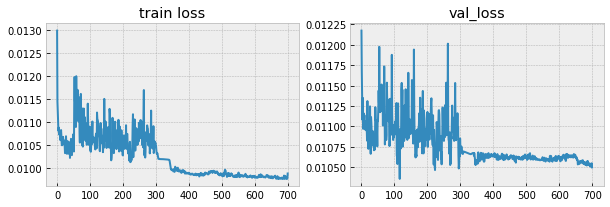

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(metrics['L_train'])
ax[0].set_title('train loss')

ax[1].plot(metrics['L_val'])
ax[1].set_title('val_loss')
plt.show()

Text(0.5, 1.0, 'segmentation mask with active learning')

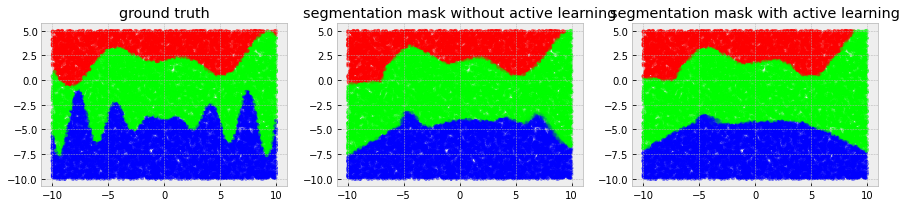

In [13]:
cloud_pred2 = model2(torch.tensor(cloud).float().to(model2.device)).detach().numpy()

fig, ax = plt.subplots(1, 3, figsize = (15, 3))

ax[0].scatter(cloud[:, 0], cloud[:, 1], c = cloud_labels, s = 10, alpha = .5)
ax[0].set_title('ground truth')

ax[1].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred, s =10, alpha = .5)
ax[1].set_title('segmentation mask without active learning')

ax[2].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred2, s =10, alpha = .5)
ax[2].set_title('segmentation mask with active learning')


In [ ]:
u = joblib.load('aug.pt')

u.keys()

dict_keys(['x', 'y'])

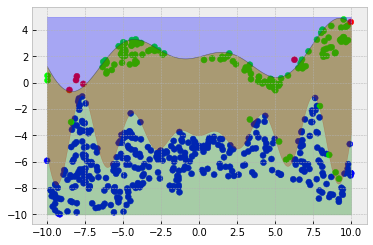

In [ ]:
plt.scatter(u['x'][:, 0], u['x'][:, 1], c = u['y'])
plt.fill_between(x, bound2, bound1, color = 'r', alpha = .3)
plt.fill_between(x, bound1, ymax, color = 'b', alpha = .3)
plt.fill_between(x, ymin, bound1, color='g', alpha=.3)